# AutoML and Ensemble Learning with H2O.ai 

* [Introduction to H2O ai](https://medium.com/@jamal.robinson/introduction-to-h2o-ai-1ba51a884f02)
* [getting started](http://docs.h2o.ai/h2o/latest-stable/h2o-r/docs/articles/getting_started.html)
* [AutoML workflow](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
* [Performance and Prediction](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html)
* [AutoML variable importance](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/variable-importance.html)
* [Available algorithms](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html)

In [ ]:
install.packages( 'h2o' )

In [1]:
library( readr )
library( dplyr )
library( GGally )


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



# Funky data example

In [2]:
funky_data <- read_csv( "funkydata.csv" ) %>% 
    mutate( Y = factor( Y ) )

Parsed with column specification:
cols(
  Gaussian1 = col_double(),
  Gaussian2 = col_double(),
  Moon1 = col_double(),
  Moon2 = col_double(),
  Circle1 = col_double(),
  Circle2 = col_double(),
  Y = col_double()
)


In [3]:
library( skimr )


Attaching package: ‘skimr’

The following object is masked from ‘package:stats’:

    filter



In [4]:
skim_to_wide( funky_data )

ERROR: Error in env_bind(mask, ... = env_get(current_env(), "...")): could not find function "env_bind"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


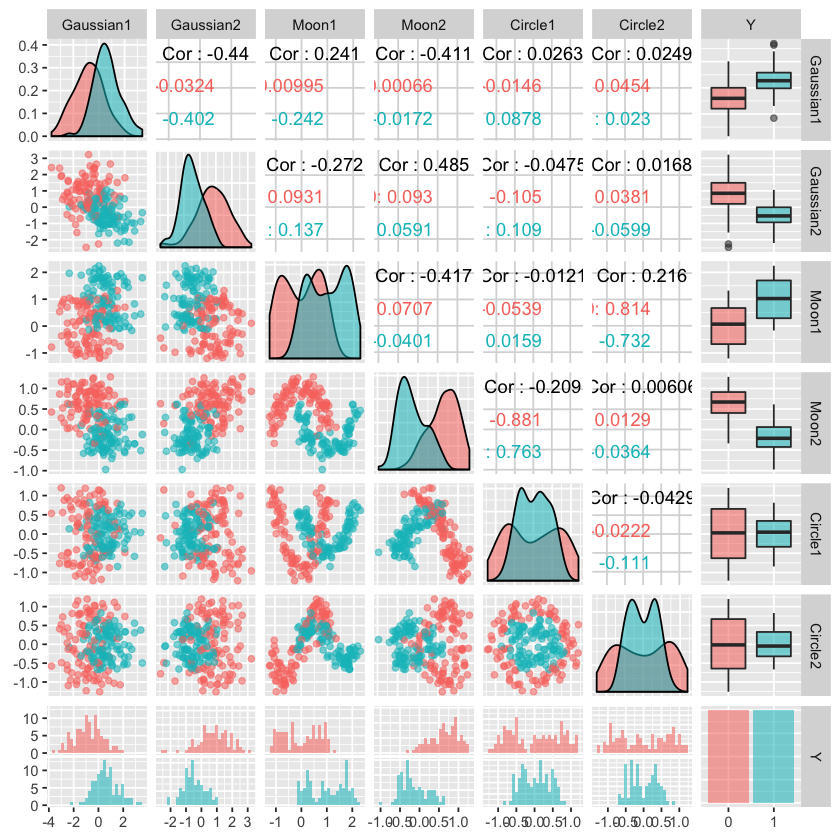

In [5]:
ggpairs( funky_data, aes( alpha=0.1, color=Y ) )

In [6]:
library(h2o)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



In [7]:
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/8j/_h7w48591zq59klcljxctvcs25_0zh/T//RtmpdOomPF/h2o_colettace_started_from_r.out
    /var/folders/8j/_h7w48591zq59klcljxctvcs25_0zh/T//RtmpdOomPF/h2o_colettace_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 654 milliseconds 
    H2O cluster timezone:       America/New_York 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.24.0.5 
    H2O cluster version age:    8 days  
    H2O cluster name:           H2O_started_from_R_colettace_nwt608 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.56 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
   

In [8]:
funky_data = as.h2o( funky_data )

  |======================================================================| 100%


In [9]:
class( funky_data )

[1] "H2OFrame"

In [10]:
summary( funky_data )

Warning message in summary.H2OFrame(funky_data):
“Approximated quantiles computed! If you are interested in exact quantiles, please pass the `exact_quantiles=TRUE` parameter.”

 Gaussian1          Gaussian2         Moon1              Moon2            
 Min.   :-3.70164   Min.   :-2.4650   Min.   :-1.20354   Min.   :-0.9726  
 1st Qu.:-0.92574   1st Qu.:-0.6316   1st Qu.:-0.09335   1st Qu.:-0.2183  
 Median :-0.01343   Median : 0.1066   Median : 0.46347   Median : 0.2632  
 Mean   :-0.09543   Mean   : 0.1677   Mean   : 0.50255   Mean   : 0.2487  
 3rd Qu.: 0.76956   3rd Qu.: 0.9259   3rd Qu.: 1.04960   3rd Qu.: 0.6657  
 Max.   : 3.38425   Max.   : 3.2245   Max.   : 2.24426   Max.   : 1.2825  
 Circle1            Circle2             Y     
 Min.   :-1.21187   Min.   :-1.258472   0:100 
 1st Qu.:-0.44734   1st Qu.:-0.474603   1:100 
 Median : 0.04368   Median :-0.044858         
 Mean   : 0.01718   Mean   :-0.002766         
 3rd Qu.: 0.47565   3rd Qu.: 0.432842         
 Max.   : 1.19801   Max.   : 1.200726         

## Split into train val test

* H2O you give your "desired" train/val/test ratios and it gives you back approximately the proportions you want
* E.g., Say we want 500 samples for training, 100 samples for validation and 400 samples for test data:

In [15]:
funky_splits <- h2o.splitFrame( funky_data, ratios=c(0.5) ) 

In [16]:
funky_train <- funky_splits[[1]]
funky_test <- funky_splits[[2]]

In [17]:
dim( funky_train )

[1] 100   7

In [18]:
dim( funky_test )

[1] 100   7

In [20]:
library(tictoc)

In [21]:
tic()
aml_results <- h2o.automl(
    # x is omitted since we want to use all the columns except "Y" as predictors
    y = 'Y',
    training_frame = funky_train,
    leaderboard_frame = funky_test,
    max_runtime_secs = 360, # Default time is one hour!!
    exclude_algos = 'GBM',
)
toc()

  |======================================================================| 100%
311.277 sec elapsed


## AutoML results

* Printing the results object shows you info from the winning "leader" model, and well as the "leaderboard" of how well the various models performed

In [22]:
dim( aml_results@leaderboard )

[1] 221   6

In [25]:
tail( aml_results@leaderboard, 100 )

model_id,auc,logloss,mean_per_class_error,rmse,mse
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XGBoost_grid_1_AutoML_20190627_142635_model_86,0.9910241,0.2365295,0.04365565,0.2419105,0.05852067
DeepLearning_grid_1_AutoML_20190627_142635_model_14,0.9906161,0.3450636,0.03488372,0.1759696,0.03096529
XGBoost_grid_1_AutoML_20190627_142635_model_53,0.9902081,0.2335524,0.04365565,0.2394703,0.05734602
DeepLearning_grid_1_AutoML_20190627_142635_model_7,0.9902081,0.1306219,0.03488372,0.2058051,0.04235572
XGBoost_grid_1_AutoML_20190627_142635_model_11,0.9898001,0.2587976,0.04365565,0.2549810,0.06501529
XGBoost_grid_1_AutoML_20190627_142635_model_154,0.9893921,0.6025664,0.03202774,0.4527922,0.20502079
XGBoost_grid_1_AutoML_20190627_142635_model_3,0.9889841,0.4574758,0.02039984,0.3698148,0.13676300
XGBoost_grid_1_AutoML_20190627_142635_model_43,0.9889841,0.2212404,0.04079967,0.2319995,0.05382375
XGBoost_grid_1_AutoML_20190627_142635_model_183,0.9885761,0.2505182,0.04365565,0.2505650,0.06278284


In [26]:
getParms( aml_results@leader )
# or a synonym:
# aml_results@leader@parameters

$model_id
[1] "XGBoost_grid_1_AutoML_20190627_142635_model_152"

$training_frame
[1] "automl_training_RTMP_sid_8130_6"

$nfolds
[1] 5

$keep_cross_validation_models
[1] FALSE

$keep_cross_validation_predictions
[1] TRUE

$fold_assignment
[1] "Modulo"

$stopping_metric
[1] "logloss"

$stopping_tolerance
[1] 0.05

$seed
[1] "-756417629423373996"

$distribution
[1] "bernoulli"

$ntrees
[1] 139

$max_depth
[1] 10

$min_rows
[1] 0.1

$learn_rate
[1] 0.05

$sample_rate
[1] 0.8

$col_sample_rate
[1] 0.8

$col_sample_rate_per_tree
[1] 0.7

$score_tree_interval
[1] 5

$reg_lambda
[1] 0.1

$reg_alpha
[1] 1

$x
[1] "Gaussian1" "Gaussian2" "Moon1"     "Moon2"     "Circle1"   "Circle2"  

$y
[1] "Y"

In [27]:
as.data.frame( predict( aml_results@leader, funky_test ) )

  |======================================================================| 100%


predict,p0,p1
<fct>,<dbl>,<dbl>
0,0.95283109,0.04716890
0,0.89933240,0.10066757
0,0.96758604,0.03241394
0,0.97804749,0.02195249
0,0.96685839,0.03314162
0,0.92642659,0.07357342
0,0.96991259,0.03008739
1,0.02038223,0.97961777
0,0.92610741,0.07389262
